# Lab 2 - Classification 

## MSDS 7331-401

#### Project Team:
+ Peter Byrd 
+ Matthew Przybyla  
+ David Tran
+ Amber Whelpley

# National Highway Traffic Safety Administration - 2015 Traffic Accidents



In [2]:
import pandas as pd
import numpy as np
import datetime
from __future__ import print_function 

import warnings
#warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore')

import seaborn as sns
sns.set(style="white", color_codes=True)
import matplotlib.pyplot as plt

from scipy import special 


#Read the Data
df = pd.read_csv("/Users/pbyrd/Data/NHTSA/accident.csv")

#Review the data
df.head()

,STATE,ST_CASE,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERNOTMVIT,PERMVIT,PERSONS,COUNTY,...,NOT_MIN,ARR_HOUR,ARR_MIN,HOSP_HR,HOSP_MN,CF1,CF2,CF3,FATALS,DRUNK_DR
0,1,10001,1,1,0,0,0,1,1,127,...,99,2,58,88,88,0,0,0,1,1
1,1,10002,1,1,0,0,0,1,1,83,...,99,22,20,88,88,0,0,0,1,0
2,1,10003,1,1,0,0,0,2,2,11,...,99,1,45,99,99,0,0,0,1,1
3,1,10004,1,1,0,0,0,1,1,45,...,99,1,15,88,88,0,0,0,1,1
4,1,10005,2,2,0,0,0,2,2,45,...,99,7,16,88,88,0,0,0,1,0



# Data Preparation

The following section will clean up some issues in the data.  We will remove invalid Latitude and Longitude coordinates, simplify the time of the crash to a single time value, and replace the state codes with the actual names of the states.  We will also combine attributes for persons involved in the accident, and create a few one-hot encoded attributes from Rural/Urban and Workzone.

New features were developed from the dataset.  The feature RUSH_HR was created to determine if rush hour traffic was a key factor in fatalities and collisions.  The feature lapseTime represents the time between the crash occuring and when EMS delivers the victim to the hospital, and could also be a factor in determining whether a fatality or collision occurred.

New ordinal variables were also created for lighting condition and weather condition.  The original variables for lighting (LGT_COND) was reordered to represent a new ordinal variable (light) to scale from lightest to darkest conditions.  Similarly, the original variable for weather condition (WEATHER) was reordered to represent a new ordinal variable (weather) to scale from best to worst weather conditions.


In [3]:
# Missing Latitude and Longitude data

# If 99.9999/88.8888/77.7777 and 999.9999/888.8888/777.7777 appear in the data we won't be able to graph them.
# We will make them 0 and we can omit them when mapping.

df['LATITUDE'] = df['LATITUDE'].replace(to_replace=99.9999,value=0) # replace unknown LATITUDE with 0 for mapping
df['LATITUDE'] = df['LATITUDE'].replace(to_replace=88.8888,value=0) # replace not available LATITUDE with 0 for mapping
df['LATITUDE'] = df['LATITUDE'].replace(to_replace=77.7777,value=0) # replace not reported LATITUDE with 0 for mapping

df['LONGITUD'] = df['LONGITUD'].replace(to_replace=999.9999,value=0) # replace unknown LONGITUD with 0 for mapping
df['LONGITUD'] = df['LONGITUD'].replace(to_replace=888.8888,value=0) # replace unknown LONGITUD with 0 for mapping
df['LONGITUD'] = df['LONGITUD'].replace(to_replace=777.7777,value=0) # replace unknown LONGITUD with 0 for mapping


In [4]:
# Add attribute for total time lapse between Crash time and Hospital arrival time

df['lapseTime'] = (df['HOSP_HR'] - df['HOUR'])*60 + (df['HOSP_MN'] - df['MINUTE'])
df['lapseTime'] = (df['lapseTime'] < 1440) * df['lapseTime'] # Keep only lapseTime less than a day (1440 mins)
df['lapseTime'] = (df['lapseTime'] > 0) * df['lapseTime']     # Remove lapseTime that are negative

In [5]:
# Naming the States 
# Reference: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 - Page 93 

states = {1: 'Alabama', 2: 'Alaska', 3: 'American Samoa', 4: 'Arizona', 5: 'Arkansas', 
          6: 'California', 8: 'Colorado', 9: 'Connecticut', 10: 'Delaware', 11: 'District of Columbia',
          12: 'Florida', 13: 'Georgia',14: 'Guam', 15: 'Hawaii', 
          16: 'Idaho', 17: 'Illinois', 18: 'Indiana', 19: 'Iowa', 20: 'Kansas', 
          21: 'Kentucky', 22: 'Louisiana', 23: 'Maine', 24: 'Maryland', 
          25: 'Massachusetts', 26: 'Michigan', 27: 'Minnesota', 
          28: 'Mississippi', 29: 'Missouri', 30: 'Montana', 31: 'Nebraska', 
          32: 'Nevada', 33: 'New Hampshire', 34: 'New Jersey', 35: 'New Mexico', 
          36: 'New York', 37: 'North Carolina', 38: 'North Dakota', 39: 'Ohio', 
          40: 'Oklahoma', 41: 'Oregon', 42: 'Pennsylvania', 43: 'Puerto Rico', 
          44: 'Rhode Island', 45: 'South Carolina', 46: 'South Dakota', 47: 'Tennessee', 
          48: 'Texas', 49: 'Utah', 50: 'Vermont', 51: 'Virginia', 52: 'Virgin Islands', 
          53: 'Washington', 54: 'West Virginia', 55: 'Wisconsin', 56: 'Wyoming'}

df['state']=df['STATE'].apply(lambda x: states[x])

In [6]:
# Lighting Condition

# Order from best to worst lighting condition
lighting = {0:1, 1:1, 2:4, 3:3, 4:2, 5:2, 6:5, 7:6, 8:6, 9:6}

df['light']=df['LGT_COND'].apply(lambda x: lighting[x])

In [7]:
# Weather condition

# Order from best to worst weather condition
weathertype = {0:1, 1:1, 2:3, 3:5, 4:3, 5:4, 6:6, 7:6, 8:6, 9:6, 10:2 ,11:6 , 12:5, 98:7 , 99:7}

# New order:
#   No additional weather, Clear
#   Cloudy
#   Rain, Snow
#   Fog
#   Sleet/Hail, Freezing Rain
#   Severe crosswinds, Blowing sand/soil, Blowing snow
#   Not reported, Unknown

df['weather']=df['WEATHER'].apply(lambda x: weathertype[x])

In [8]:
# Let's combine some attributes for easier interpretation:

# Total number of persons involved in the accident
df['TOT_PERS'] = df['PERMVIT'] + df['PERNOTMVIT'] + df['PEDS']

# Let's create a binary attributes from some of our categorical variables 
df['FATALS'] = (df['FATALS'] > 1)*1     # 1 = multi-fatality, 0 = single-fatality
df['WRK_ZONE'] = (df['WRK_ZONE']>0)*1   # 1 = workzone, 0 = not workzone
df['RUR_URB'] = (df['RUR_URB']<2)*1     # 1 = urban, 0 = rural
df['DRUNK'] = (df['DRUNK_DR']>0)*1      # 1 = drunk, 0 = not drunk
df['NHS'] = (df['NHS']>0)*1             # 1 = national hwy, 0 = not on national hwy (assume not reported = 1 (4%))
df['SP_JUR'] = (df['SP_JUR']>0)*1       # 1 = special jurisdiction, 0 = no special jurisdiction
df['intersetion'] = (df['TYP_INT']>1)*1 # 1 = intersection, 0 = not an intersection
df['collision'] = (df['MAN_COLL']>0)*1  # 1 = collision, 0 = no collision


# Add new attribute of RUSH_HR (6am - 8:59am or 4pm - 6:59pm)
tmp1 = df['HOUR'] > 5
tmp2 = df['HOUR'] < 9
tmp3 = df['HOUR'] > 15
tmp4 = df['HOUR'] < 19
df['RUSH_HR'] = (tmp1 * tmp2)*1 + (tmp3 * tmp4)*1


In [9]:
# Remove non-helpful and duplicate attributes 
# Correlation matrix was used to determine attributes with limited correlation to FATALS
# Some categorical/coded variables were removed

excludeFields = ['ST_CASE','VE_CASE','VE_FORMS','PEDS','PERNOTMVIT','PERMVIT','PERSONS','DAY','MONTH',
                 'YEAR','HOUR','MINUTE','PVH_INVL','FUNC-SYS','RD_OWNER','TWAY_ID','CITY','COUNTY','TYP_INT',
                 'TWAY_ID2','MILEPT','RELJCT1','RELJCT2', 'REL_ROAD','LGT_COND','FUNC_SYS','DAY_WEEK',
                 'RAIL','NOT_HOUR','NOT_MIN','ARR_HOUR','ARR_MIN','HOSP_HR','HOSP_MN','STATE','DRUNK_DR','CF1','CF2','CF3',
                 'state','WEATHER','WEATHER1','WEATHER2','HARM_EV','MAN_COLL']

keepFields = [col for col in df.columns if col not in excludeFields]

df = df[keepFields]

#df.head(20)
df.describe()

,VE_TOTAL,NHS,RUR_URB,ROUTE,LATITUDE,LONGITUD,SP_JUR,WRK_ZONE,SCH_BUS,FATALS,lapseTime,light,weather,TOT_PERS,DRUNK,intersetion,collision,RUSH_HR
count,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000
mean,1.556177,0.392744,0.475440,3.758472,36.380743,-91.516946,0.011005,0.019959,0.003295,0.073059,12.361064,2.316235,1.480849,2.720201,0.275508,0.243829,0.381925,0.265809
std,0.889722,0.488368,0.499404,2.056157,5.962369,16.525763,0.104329,0.139861,0.057312,0.260237,28.697905,1.356920,0.973833,2.011871,0.446777,0.429397,0.485866,0.441770
min,1.000000,0.000000,0.000000,1.000000,0.000000,-166.549556,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,2.000000,32.997464,-97.830091,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,3.000000,36.314125,-87.641267,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,1.000000,1.000000,6.000000,40.566313,-81.308249,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,3.000000,1.000000,0.000000,1.000000,1.000000
max,58.000000,1.000000,1.000000,9.000000,65.176558,0.000000,1.000000,1.000000,1.000000,1.000000,1029.000000,6.000000,7.000000,93.000000,1.000000,1.000000,1.000000,1.000000


### Review Feature Correlations

To easily identify and remove highly correlated features that may impact our analysis, a correlation heatmap was used.

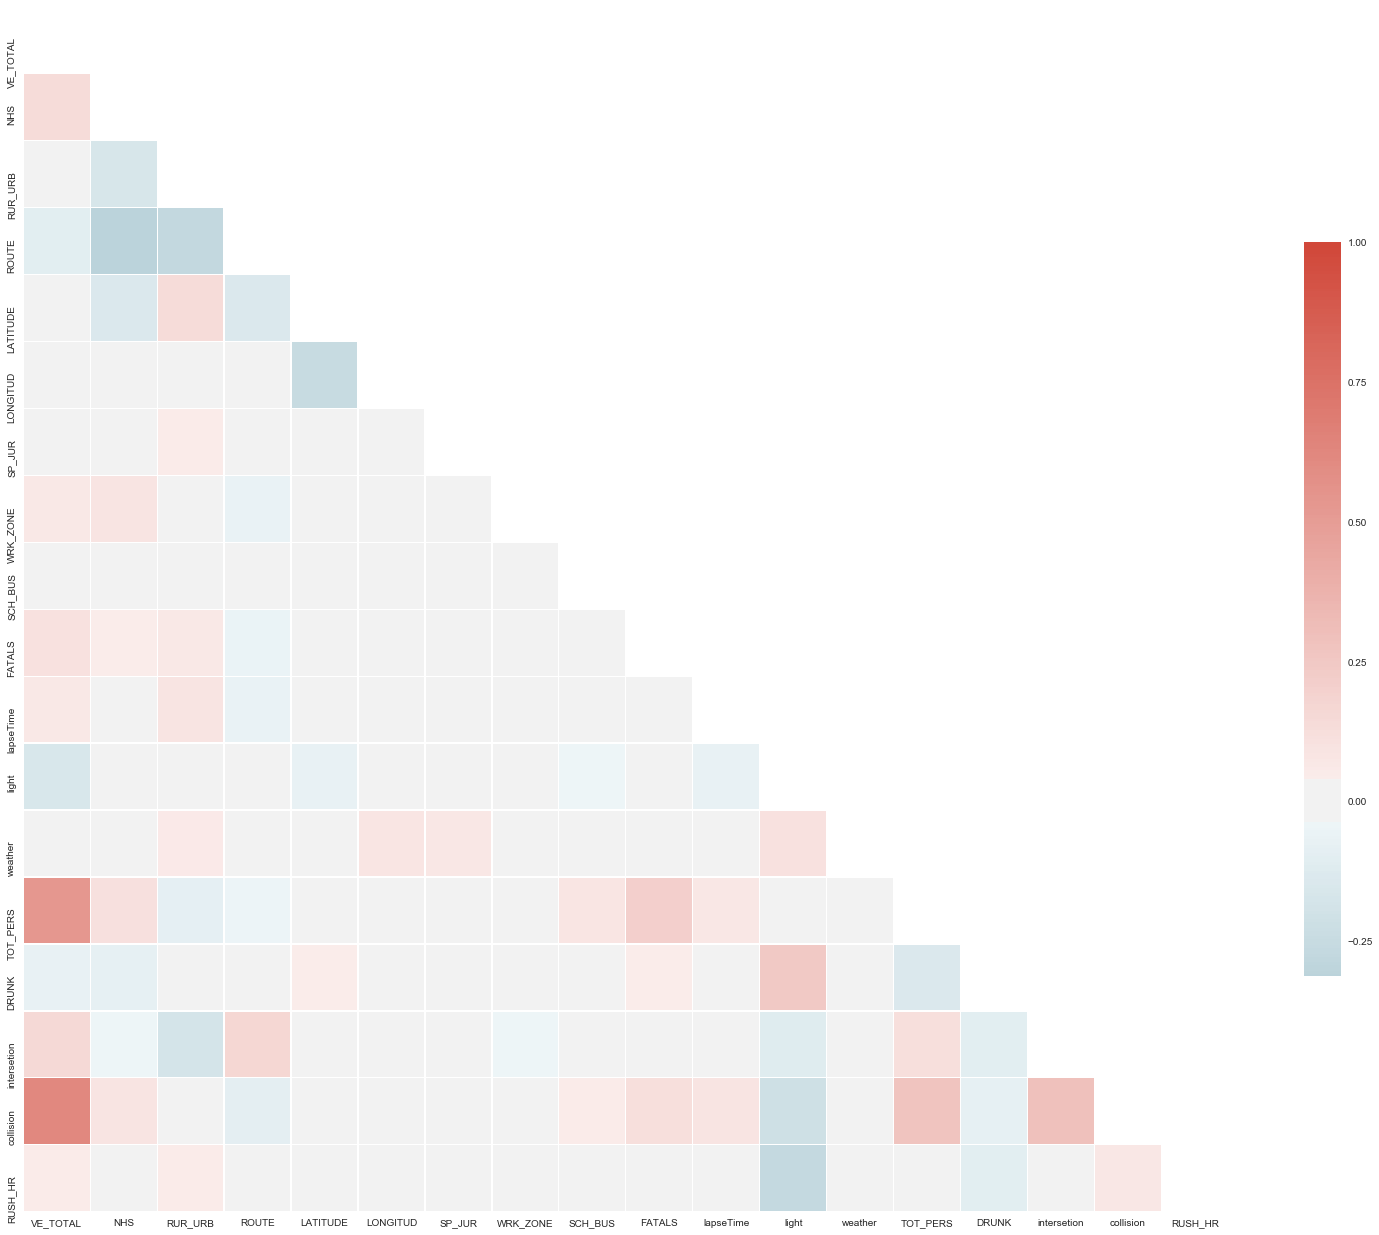

In [10]:
%matplotlib inline

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(27, 27))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, center=0,
            square=True, linewidths=.2, cbar_kws={"shrink": .5})


**Remove VE_TOTAL**    
From the coorelation plot, we see that total vehicles (VE_TOTAL) is highly coorelated with collisions (collision) and total persons (TOT_PERS).  We will remove VE_TOTAL from the dataset before performing further analysis.

In [11]:
#Drop highly coorelated attributes (VE_TOTAL) 
df.info()

# Drop the highly correlated features from our training data 
df = df.drop('VE_TOTAL', axis=1)

#Check columns after drop 
print('*********************************************')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32166 entries, 0 to 32165
Data columns (total 18 columns):
VE_TOTAL       32166 non-null int64
NHS            32166 non-null int64
RUR_URB        32166 non-null int64
ROUTE          32166 non-null int64
LATITUDE       32166 non-null float64
LONGITUD       32166 non-null float64
SP_JUR         32166 non-null int64
WRK_ZONE       32166 non-null int64
SCH_BUS        32166 non-null int64
FATALS         32166 non-null int64
lapseTime      32166 non-null int64
light          32166 non-null int64
weather        32166 non-null int64
TOT_PERS       32166 non-null int64
DRUNK          32166 non-null int64
intersetion    32166 non-null int64
collision      32166 non-null int64
RUSH_HR        32166 non-null int64
dtypes: float64(2), int64(16)
memory usage: 4.4 MB
*********************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32166 entries, 0 to 32165
Data columns (total 17 columns):
NHS            32166 non-null int

# MODELING and EVALUATION

## PART 1

## Classification of Single or Multi fatality accidents

**We will attempt to classify accidents as single-fatality or multiple-fatality accidents**    
Using logistic regression, K-nearest neighbor, and Gaussian and Bernoulli Naive Bayes models we will attempt to classify the accidents in our dataset as to whether they result in single or multiple fatalities.  For each of these models, a grid search will be used to assist in determining the most useful combination of parameters.  Model parameters are adjusted during the grid search using the **accuracy** measurement.

The intended metrics which we will use to compare models are **accuracy, precision, and recall**. Accuracy gives us a good measure of True Positives (i.e. a prediction of a single-fatality accident is indeed a single-fatality accident) and True Negatives (i.e. prediction of a multi-fatality accident is indeed a multi-fatality accident). However, accuracy ignores misclassification and as such is somewhat misleading in that it predicts single fatalities because our data is skewed that way. 

Precision penalizes the models for prediction of False Positives (i.e. prediction of a single-fatality accident when it is actually a multi-fatality accident) and good precision will lower the False Positive rate. Recall penalizes for predicting False Negatives (i.e. prediction of a multi-fatality accident when it is actually a single-fatality accident) and good recall will lower the false negatives.

Since the data is extremely skewed toward single-fatality accidents (29,816 single-fatality accidents as opposed to 2,350 multi-fatality accidents), a stratified shuffle split and 10-fold cross validation. is used with these models. The stratified split will help to ensure that all of our CV folds include a suficient number of multi-fatality accidents.

### Training and Test Split

In [12]:
# Training and Testing Split 80/20 with 10-fold cross validation

from sklearn.model_selection import StratifiedShuffleSplit

df_fatals = df

# create x explanatory and y response variable for regression
y_fatals_df = df_fatals['FATALS']
x_fatals_df = df_fatals.drop(['FATALS'],axis=1)
y_fatals = df_fatals['FATALS'].values
x_fatals = df_fatals.drop(['FATALS'],axis=1).values

cv_fatals = StratifiedShuffleSplit(n_splits=10,
                         test_size  = 0.2, train_size = 0.8, random_state=1)

cv_fatals.get_n_splits(x_fatals,y_fatals)

for train_index, test_index in cv_fatals.split(x_fatals,y_fatals):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_fatals_train, x_fatals_test = x_fatals[train_index], x_fatals[test_index]
    y_fatals_train, y_fatals_test = y_fatals[train_index], y_fatals[test_index]
   
print(cv_fatals)

# We will try to classify if an accident is a single-fatality or multiple-fatality accident
df_fatals = df_fatals.groupby(by='FATALS')
print (df_fatals.FATALS.count())

TRAIN: [10298  5849 31914 ..., 20998 23514 25284] TEST: [24083 18290 22859 ...,  2985 27413 30793]
TRAIN: [30676 18003  4719 ..., 27331  6887 10484] TEST: [30366 28359 31188 ..., 18144  7503  3832]
TRAIN: [13093 25004  5248 ..., 31979  3633   727] TEST: [18406 30199 15903 ...,  4773   471  4010]
TRAIN: [23085  8303 15777 ..., 28228  4285 22270] TEST: [28514 14170 27636 ...,  8921 19538 17703]
TRAIN: [ 4470 12124 21060 ..., 23906 31242 24530] TEST: [17446 11745  6398 ...,  7863 23098 29513]
TRAIN: [ 7866 12266 28123 ..., 30791 10688  1084] TEST: [25118  2128 18871 ..., 13902  3298  4021]
TRAIN: [  535  4134 16879 ..., 20316  6519 12527] TEST: [ 3760 14866 28046 ..., 27412 15246 21368]
TRAIN: [26890 18413 11015 ..., 29263 11478 23031] TEST: [ 1108 30148 12863 ...,  8787 14100 16968]
TRAIN: [29338  2207 25476 ...,  2255 25229 26899] TEST: [ 3931 10260   907 ..., 16498 21240 24071]
TRAIN: [28931 24414  8858 ...,  6894 19560  8011] TEST: [25119 16889  5543 ..., 22444 23503 11618]
Stratified

### Classifier Evaluation

In [13]:
#Classifier Evaluation
#We will use this evaluation criteria to compare models
from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, x, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, x, y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

### Logistic Regression

In [14]:
#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
Estimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100]
              ,'class_weight': ['balanced','none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object 
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=Estimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_fatals # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(x_fatals, y_fatals)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   38.9s
[Parallel(n_jobs=8)]: Done 240 out of 240 | elapsed:   53.4s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=1, test_size=0.2,
            train_size=0.8),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'class_weight': ['balanced', 'none'], 'random_state': [0], 'solver': ['lbfgs'], 'max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [15]:
#Display the best estimator parameters
LR_best_estimator = regGridSearch.best_estimator_
LR_best_estimator

LogisticRegression(C=0.001, class_weight='none', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [16]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(LR_best_estimator, x_fatals, y_fatals, cv_fatals)

The average accuracy for all cv folds is: 			 0.92639
The average precision for all cv folds is: 			 0.39521
The average recall for all cv folds is: 			 0.01383
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.926484,0.411765,0.014894
1,0.926640,0.450000,0.019149
2,0.926173,0.352941,0.012766
3,0.926018,0.375000,0.019149
4,0.926484,0.411765,0.014894
5,0.925707,0.277778,0.010638
6,0.926640,0.416667,0.010638
7,0.926484,0.400000,0.012766
8,0.926795,0.444444,0.008511
9,0.926484,0.411765,0.014894


In [40]:
#Store scores for model comparison
scores = cross_validate(LR_best_estimator, x_fatals, y_fatals, scoring=['accuracy','precision','recall']
                            , cv=cv_fatals, return_train_score=True)
acc_lr = scores['test_accuracy']
pre_lr = scores['test_precision']
rec_lr = scores['test_recall']

### K-Nearest Neighbor

In [26]:
#KNN 10-fold cross-validation (this takes about 8 minutes to run)
from sklearn.neighbors import KNeighborsClassifier
Estimator = KNeighborsClassifier()

parameters = { 'n_neighbors':[10,11,12,13,14],
               'weights':['uniform','distance'],
               'algorithm':['auto'],
               'leaf_size':[10,30],
               'p':[1,2]                 # p=1:manhattan, p=2:euclidean
             }

#Create a grid search object  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=Estimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_fatals # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(x_fatals, y_fatals)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   52.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:  8.4min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=1, test_size=0.2,
            train_size=0.8),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'n_neighbors': [10, 11, 12, 13, 14], 'weights': ['uniform', 'distance'], 'algorithm': ['auto'], 'leaf_size': [10, 30], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [27]:
#Display the best estimator parameters
KNN_best_estimator = regGridSearch.best_estimator_
KNN_best_estimator

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=12, p=2,
           weights='uniform')

In [28]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(KNN_best_estimator, x_fatals, y_fatals, cv_fatals)

The average accuracy for all cv folds is: 			 0.92694
The average precision for all cv folds is: 			 0.51294
The average recall for all cv folds is: 			 0.0046809
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.927106,0.666667,0.004255
1,0.927261,0.750000,0.006383
2,0.926795,0.000000,0.000000
3,0.927417,0.800000,0.008511
4,0.926795,0.333333,0.002128
5,0.926173,0.222222,0.004255
6,0.926795,0.428571,0.006383
7,0.927261,1.000000,0.004255
8,0.926795,0.428571,0.006383
9,0.926951,0.500000,0.004255


In [41]:
#Store scores for model comparison
scores = cross_validate(KNN_best_estimator, x_fatals, y_fatals, scoring=['accuracy','precision','recall']
                            , cv=cv_fatals, return_train_score=True)
acc_knn = scores['test_accuracy']
pre_knn = scores['test_precision']
rec_knn = scores['test_recall']

### Gaussian Naive Bayes

In [30]:
#Naive Bayes Gaussian 10-fold cross-validation 
from sklearn.naive_bayes import GaussianNB
Estimator = GaussianNB()

parameters = { 'priors':[None]
             }

#Create a grid search object 
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=Estimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_fatals # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(x_fatals, y_fatals)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.2s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=1, test_size=0.2,
            train_size=0.8),
       error_score='raise', estimator=GaussianNB(priors=None),
       fit_params=None, iid=True, n_jobs=8, param_grid={'priors': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [31]:
#Display the best estimator parameters
GNB_best_estimator = regGridSearch.best_estimator_
GNB_best_estimator

GaussianNB(priors=None)

In [32]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(GNB_best_estimator, x_fatals, y_fatals, cv_fatals)

The average accuracy for all cv folds is: 			 0.90431
The average precision for all cv folds is: 			 0.20491
The average recall for all cv folds is: 			 0.10723
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.907367,0.218750,0.104255
1,0.902704,0.188000,0.100000
2,0.903637,0.202381,0.108511
3,0.904725,0.238095,0.138298
4,0.906124,0.208696,0.102128
5,0.899130,0.169742,0.097872
6,0.904880,0.204167,0.104255
7,0.905191,0.210744,0.108511
8,0.907678,0.225664,0.108511
9,0.901616,0.182879,0.100000


In [42]:
#Store scores for model comparison
scores = cross_validate(GNB_best_estimator, x_fatals, y_fatals, scoring=['accuracy','precision','recall']
                            , cv=cv_fatals, return_train_score=True)
acc_gnb = scores['test_accuracy']
pre_gnb = scores['test_precision']
rec_gnb = scores['test_recall']

### Bernoulli Naive Bayes

In [35]:
#Naive Bayes Bernoulli 10-fold cross-validation 
from sklearn.naive_bayes import BernoulliNB
Estimator = BernoulliNB()

parameters = { 'alpha':[.001,.01,1,10],
               'binarize':[0, 0.1, 0.2, 0.5, 1],
               'fit_prior':[True,False]
             }

#Create a grid search object
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=Estimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_fatals # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(x_fatals, y_fatals)


Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=8)]: Done  88 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    4.0s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=1, test_size=0.2,
            train_size=0.8),
       error_score='raise',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'alpha': [0.001, 0.01, 1, 10], 'binarize': [0, 0.1, 0.2, 0.5, 1], 'fit_prior': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [36]:
#Display the best estimator parameters
BNB_best_estimator = regGridSearch.best_estimator_
BNB_best_estimator

BernoulliNB(alpha=0.001, binarize=0, class_prior=None, fit_prior=True)

In [37]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(BNB_best_estimator, x_fatals, y_fatals, cv_fatals)

The average accuracy for all cv folds is: 			 0.92695
The average precision for all cv folds is: 			 0.0
The average recall for all cv folds is: 			 0.0
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.926951,0.0,0.0
1,0.926951,0.0,0.0
2,0.926951,0.0,0.0
3,0.926951,0.0,0.0
4,0.926951,0.0,0.0
5,0.926951,0.0,0.0
6,0.926951,0.0,0.0
7,0.926951,0.0,0.0
8,0.926951,0.0,0.0
9,0.926951,0.0,0.0


In [43]:
#Store scores for model comparison
scores = cross_validate(BNB_best_estimator, x_fatals, y_fatals, scoring=['accuracy','precision','recall']
                            , cv=cv_fatals, return_train_score=True)
acc_bnb = scores['test_accuracy']
pre_bnb = scores['test_precision']
rec_bnb = scores['test_recall']

## Model Advantages and Comparison

**Logistic Regression Model**       
The average accuracy for all cv folds is: 			 0.92639    
The average precision for all cv folds is: 			 0.39521    
The average recall for all cv folds is: 			 0.01383    

**KNN Model**        
The average accuracy for all cv folds is: 			 0.92694    
The average precision for all cv folds is: 			 0.51294    
The average recall for all cv folds is: 			 0.0046809    

**GaussianNB Model**        
The average accuracy for all cv folds is: 			 0.90431    
The average precision for all cv folds is: 			 0.20491    
The average recall for all cv folds is: 			 0.10723    

**BernoulliNB Model**        
The average accuracy for all cv folds is: 			 0.92695    
The average precision for all cv folds is: 			 0.0    
The average recall for all cv folds is: 			 0.0    

The BernoulliNB model only predicts single-fatality accidents, and as such is not useful for our analysis.  

The remaining models--logistic regression, KNN, and Gaussian NB--each have poor recall. 

The **best model appears to be the Gaussian NB model**. While this model does not have quite as high accuracy (90.4% as compared to approximately 92.6% for KNN and logistic regression), the accuracy is still fairly close and, more importantly, Gaussian NB has the highest recall of any model. Due to the fact that our classification task is centered around the goal of saving human life, the ability to correctly identify relevant cases is a priority. Although the recall is only 0.11, it is still much higher than logistic regression's recall of 0.01 and KNN's of 0.005.

From a computational standpoint, the Logistic Regression model takes a while to run, and the KNN model is extremely computational intensive and time consuming.  Even with a limited neighbor list, it required over 8 minutes to run.  Another advantage to the GaussianNB is the speed at which it performs, and gives us another reason for choosing this model.

In [44]:
# Confidence Intervals for each model accuracy
mean_lr = np.mean(acc_lr)
z_lr = 1.96 * np.std(acc_lr)/ np.sqrt(10)
print ('95% Confidence interval for LogRegression:', mean_lr - z_lr, mean_lr + z_lr)

mean_knn = np.mean(acc_knn)
z_knn = 1.96 * np.std(acc_knn)/ np.sqrt(10)
print ('95% Confidence interval for KNN:', mean_knn - z_knn, mean_knn + z_knn)

mean_gnb = np.mean(acc_gnb)
z_gnb = 1.96 * np.std(acc_gnb)/ np.sqrt(10)
print ('95% Confidence interval for GaussianNB:', mean_gnb - z_gnb, mean_gnb + z_gnb)

mean_bnb = np.mean(acc_bnb)
z_bnb = 1.96 * np.std(acc_bnb)/ np.sqrt(10)
print ('95% Confidence interval for BernoulliNB:', mean_bnb - z_bnb, mean_bnb + z_bnb)

95% Confidence interval for LogRegression: 0.926197420658 0.926584674462
95% Confidence interval for KNN: 0.926726409999 0.927143655279
95% Confidence interval for GaussianNB: 0.902757286892 0.905853219791
95% Confidence interval for BernoulliNB: 0.92695057507 0.92695057507


The 95% confidence intervals overlap for LogRegression and KNN, and they are therefore not significantly different.  Confidence intervals for BernoulliNB are the best, but this model doesn't predict anything other than single fatality, and is therefore not useful.  

In [46]:
# Confidence Intervals for each model recall
mean_lr = np.mean(rec_lr)
z_lr = 1.96 * np.std(rec_lr)/ np.sqrt(10)
print ('95% Confidence interval for LogRegression recall:', mean_lr - z_lr, mean_lr + z_lr)

mean_knn = np.mean(rec_knn)
z_knn = 1.96 * np.std(rec_knn)/ np.sqrt(10)
print ('95% Confidence interval for KNN recall:', mean_knn - z_knn, mean_knn + z_knn)

mean_gnb = np.mean(rec_gnb)
z_gnb = 1.96 * np.std(rec_gnb)/ np.sqrt(10)
print ('95% Confidence interval for GaussianNB recall:', mean_gnb - z_gnb, mean_gnb + z_gnb)

mean_bnb = np.mean(rec_bnb)
z_bnb = 1.96 * np.std(rec_bnb)/ np.sqrt(10)
print ('95% Confidence interval for BernoulliNB recall:', mean_bnb - z_bnb, mean_bnb + z_bnb)

95% Confidence interval for LogRegression recall: 0.011765637226 0.0158939372421
95% Confidence interval for KNN recall: 0.00326052777544 0.00610117435222
95% Confidence interval for GaussianNB recall: 0.100427519439 0.114040565667
95% Confidence interval for BernoulliNB recall: 0.0 0.0


None of the 95% confidence intervals for recall overlap, and therefore each is significantly different.  GaussianNB has the best recall of all the models.

## Feature Importance

The features will be scaled to zero mean and unit variance for determining feature importance.  

In [24]:
#Scale our dataset to zero mean and unit variance for determining feature importance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt

scaler = StandardScaler()
gnb = GaussianNB()

#Fit to data for scaling and scale x_train and x_test
scaler.fit(x_fatals_train) 
x_fatals_train_scl = scaler.transform(x_fatals_train)
x_fatals_test_scl = scaler.transform(x_fatals_test)

#Fit the scaled data to our chosen model
gnb.fit(x_fatals_train_scl,y_fatals_train)
y_hat = gnb.predict(x_fatals_test_scl)
print("Number of mislabeled points out of a total %d points : %d"
       % (x_fatals_test.shape[0],(y_fatals_test != y_hat).sum()))
acc = accuracy_score(y_fatals_test, y_hat, sample_weight=None)
conf = mt.confusion_matrix(y_fatals_test,y_hat)
print('The accuracy for our scaled model is:', acc)
print('This is almost identical to our mean accuracy using cross validation.')
print('The confustion matrix is:')
print(conf)


Number of mislabeled points out of a total 6434 points : 633
The accuracy for our scaled model is: 0.901616412807
This is almost identical to our mean accuracy using cross validation.
The confustion matrix is:
[[5754  210]
 [ 423   47]]


In [25]:
mean_feature_per_class = pd.DataFrame(gnb.theta_.T)
features = pd.DataFrame(x_fatals_df.columns)

mean_per_class = pd.concat([features, mean_feature_per_class], axis=1)
mean_per_class.columns = ['Features', 'Single-Fatality', 'Multi-Fatality']
mean_per_class = mean_per_class.set_index('Features')
mean_per_class.sort_values(by='Multi-Fatality', inplace=True)
print('\nThis provides the mean of each feature per class (single or multi fatality):')
mean_per_class


This provides the mean of each feature per class (single or multi fatality):


,Single-Fatality,Multi-Fatality
Features,,
ROUTE,0.018204,-0.230962
intersetion,0.004611,-0.058507
RUSH_HR,0.002558,-0.032451
LONGITUD,0.002499,-0.031708
light,0.000982,-0.012456
LATITUDE,0.000563,-0.007141
weather,0.000390,-0.004951
WRK_ZONE,0.000298,-0.003785
SCH_BUS,-0.001069,0.013568


The table above provides the feature mean for each classification - both single and multi-fatality accidents. It shows us the importance of each of the features for the classification task where the greater the feature mean for that classification, the more important the feature is for the classification. Therefore, TOT_pers, collision, RUR_URB, NHS, DRUNK, and lapseTime are the most important features here for classifying multi-fatality.

These features make sense in this context because the higher the number of people involved in an accident, you would expect a higher likelihood of a multi-fatality. This is similar with collision, as a collision involves more vehicles and people. Drunk drivers being involved, as expected, influence an accident toward multiple fatalities.

The lapseTime variable shows that the longer the time elapsed between the accident and the victim's arrival at the hospital, the higher likelihood of a multi-fatality accident. This is logical because of the importance of injured people receiving medical attention as soon as it is possible.

In interpreting feature importance, visual aid can sometimes be helpful at first. The graphs below show the coefficients found by our logistic regression model which, although it is not the model that we chose as the best, still gives insight into the features that impact the number of fatalities in an accident. The features highlighted here are approximately the same as those mentioned from the table above.

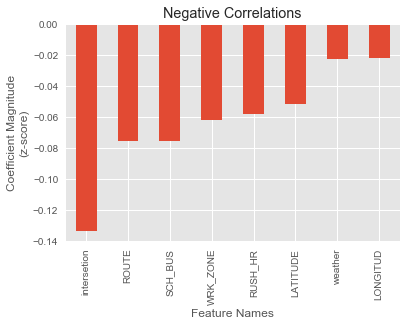

In [26]:
#Lets look at regression coefficients
gnb = LogisticRegression()
gnb.fit(x_fatals_train_scl,y_fatals_train)
y_hat = gnb.predict(x_fatals_test_scl)

#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = gnb.coef_.T.flatten()
#print(weights)
feature_names = x_fatals_df.columns
#print(feature_names)
gnb_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
gnb_ft_imp_df.sort_values(by='weights', inplace=True)

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = gnb_ft_imp_df.head(8)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar')

ax.set_title("Negative Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

# sort these attributes and spit them out
# zip_vars = zip(lr.coef_.T,x_fatals_df.columns) # combine attributes
# for coef, name in sorted(zip_vars):
#     print(name, 'has weight of', coef[0]) # now print them out

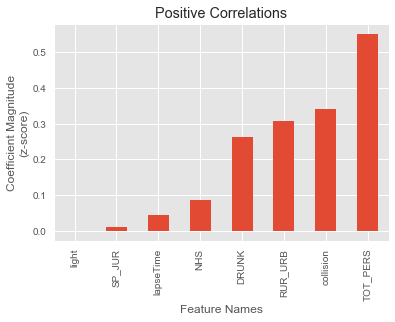

In [27]:
#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = gnb_ft_imp_df.tail(8)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar')

ax.set_title("Positive Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()


The two plots above show the most highly coorelated features for multi-fatality accidents.  Total persons, collisions, urban driving and drunk driving are all positively coorelated with multiple fatality accidents.  The negative coorelations are less significant, but intersections and smaller roads (routes) are the most significant negative coorelations.

The accuracy of the model we *did* choose, the Gaussian NB, is shown below.

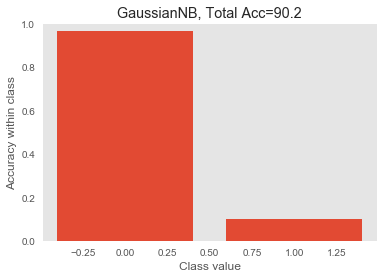

In [86]:
# Visualize the Accuracy of the GaussianNB 

def per_class_accuracy(ytrue,y_hat):
    conf = mt.confusion_matrix(ytrue,y_hat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,y_hat, title=''):
    acc_list = per_class_accuracy(ytrue,y_hat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,y_hat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()


plot_class_acc(y_fatals_test,y_hat,title="GaussianNB")

In [120]:
from sklearn import metrics as mt

# get various measures of performance
total_accuracy = mt.accuracy_score(y_fatals_test,y_hat)
per_class_acc_list = per_class_accuracy(y_fatals_test,y_hat)

rec_tot = []
prec_tot = []

for cls in np.unique(y_fatals_test):
    idx = (y_fatals_test==cls) # get classes
    ytmp_actual = np.zeros(y_fatals_test.shape) # make binary class problem
    ytmp_actual[idx] = 1 # set the instances for this specific class
    
    ytmp_predicted = np.zeros(y_fatals_test.shape) # binary prediction array
    ytmp_predicted[y_hat==cls] = 1
    
    num_in_class = sum(idx)
    
    rec = mt.recall_score(ytmp_actual, ytmp_predicted)
    prec = mt.precision_score(ytmp_actual, ytmp_predicted)
    rec_tot.append(rec)
    prec_tot.append(prec)
        
print ('Total Accuracy:',total_accuracy)


Total Accuracy: 0.901616412807


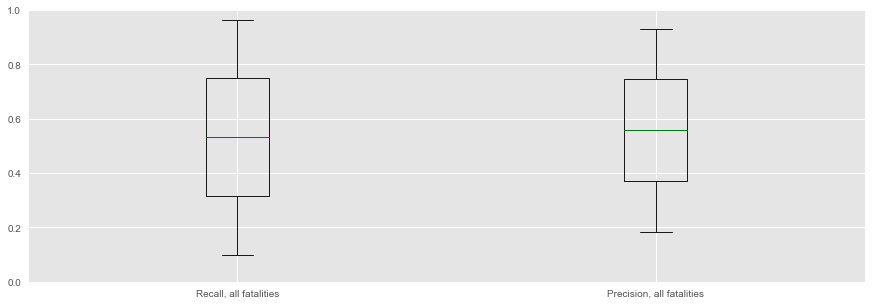

In [121]:
# But we can really summarize this data much better than this. 
# How about looking at more statistics of the precision and recall for each class?

import seaborn as sns
sns.set_palette("dark")
plt.figure(figsize=(15,5))
plt.boxplot([ rec_tot, prec_tot],
            labels=['Recall, all fatalities','Precision, all fatalities'])
plt.ylim([0,1])
plt.show()

The box and whisker plots shown here provide a quick view of the statistical composition of the precision and recall of our chosen model. The ends represent the floor (lowest) and ceiling (highest) values. The top and bottom of the boxes represent the values at 25% and 75% of our plotted data, while the median value is shown by the center line.

## PART 2

## Classification of Collision/No-collision accidents

**We will classify accidents into those that result in collisions or no collision**

The dataset includes information for several types of motor vehicle collisions, including head-on, sideswipe, rear-end and other types of collision. This information is listed for those accidents in the dataset for which "first harmful event" is listed as a collision between two or more motor vehicles. Those that do not have this event listed have a "0" for the MAN_COLL (manner of collision) variable. To reduce this information to a binary classifier, we retained all non-collision accidents as a "0" and combined each type of collision into a "1" in a new variable named *collision*.
 
Once again using logistic regression, K-nearest neighbor, and Gaussian and Bernoulli Naive Bayes models we will attempt to classify the accidents in our dataset as to whether each accident involved a collision with another vehicle.    
For each of these models, a grid search will be used to assist in determining the most useful combination of parameters.

When compared to the number of fatalities, this variable is not nearly as highly skewed: 19,881 (62%) accidents did not involve a collision with another motor vehicle while 12,285 (38%) did.

### Training and Test Split


In [47]:
# Training and Testing Split 80/20 with 10 fold cross validation

from sklearn.model_selection import StratifiedShuffleSplit

df_collision = df

# create x explanatory and y response variable for regression
y_collision_df = df_collision['collision']
x_collision_df = df_collision.drop(['collision'],axis=1)
y_collision = df_collision['collision'].values
x_collision = df_collision.drop(['collision'],axis=1).values

cv_collision = StratifiedShuffleSplit(n_splits=10,
                         test_size  = 0.2, train_size = 0.8, random_state=1)

cv_collision.get_n_splits(x_collision,y_collision)

for train_index, test_index in cv_collision.split(x_collision,y_collision):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_collision_train, x_collision_test = x_collision[train_index], x_collision[test_index]
    y_collision_train, y_collision_test = y_collision[train_index], y_collision[test_index]

print(cv_collision)
    
# We will classify accidents on if there was a collision
df_collision = df.groupby(by='collision')
print (df_collision.collision.count())

TRAIN: [ 3149 28518 10655 ..., 20569 16467 23754] TEST: [14743 21781 20614 ..., 26957 19563  7755]
TRAIN: [21230 14926 17028 ...,  6740 23747 16429] TEST: [26193  9326 32146 ..., 18677 20266 30084]
TRAIN: [  434 30556 14127 ...,  9187 18959 30275] TEST: [21986 17964 29035 ..., 12827 22285 31219]
TRAIN: [31747 10237 28365 ..., 14365 24012 15226] TEST: [20309  2238 30807 ..., 26386 12482 20199]
TRAIN: [ 8477  2940 13446 ..., 17723  8644 19745] TEST: [ 6290  9116 27127 ..., 24203 20562 28357]
TRAIN: [11422  6465 16003 ..., 22966 30613 28562] TEST: [24957 12040  1782 ...,  8346 19303 25996]
TRAIN: [12488 21406  8035 ..., 14583  2872 25086] TEST: [ 4039 15707 15101 ..., 11516  2990 19964]
TRAIN: [ 7324  1992  7901 ..., 12964 15518 21010] TEST: [ 5611  3063  7769 ..., 11197 15237  9335]
TRAIN: [14206 19955 26959 ..., 16722 30731 19931] TEST: [19823 22292 11995 ..., 16101  1016 15855]
TRAIN: [ 1398 16149  7296 ..., 22722 18554 29060] TEST: [6363 5528 7133 ..., 2111 4649   39]
StratifiedShuffl

### Logistic Regression

In [48]:
#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
Estimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100]
              ,'class_weight': ['balanced','none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=Estimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_collision # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(x_collision, y_collision)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   39.5s
[Parallel(n_jobs=8)]: Done 240 out of 240 | elapsed:   55.0s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=1, test_size=0.2,
            train_size=0.8),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'class_weight': ['balanced', 'none'], 'random_state': [0], 'solver': ['lbfgs'], 'max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [49]:
#Display the best estimator parameters
LR_best_estimator = regGridSearch.best_estimator_
LR_best_estimator

LogisticRegression(C=0.1, class_weight='none', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(LR_best_estimator, x_collision, y_collision, cv_collision)

The average accuracy for all cv folds is: 			 0.7258
The average precision for all cv folds is: 			 0.68381
The average recall for all cv folds is: 			 0.5247
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.726609,0.683684,0.528694
1,0.731427,0.702163,0.515263
2,0.731116,0.691014,0.535206
3,0.723656,0.678590,0.525031
4,0.715107,0.663180,0.516077
5,0.723966,0.682183,0.518926
6,0.726142,0.686127,0.521368
7,0.726919,0.684405,0.528694
8,0.730028,0.687305,0.537648
9,0.723034,0.679426,0.520147


In [53]:
#Store scores for model comparison
scores = cross_validate(LR_best_estimator, x_collision, y_collision, scoring=['accuracy','precision','recall']
                            , cv=cv_collision, return_train_score=True)
acc_lr = scores['test_accuracy']
pre_lr = scores['test_precision']
rec_lr = scores['test_recall']

### K-Nearest Neighbor

In [52]:
#KNN 10-fold cross-validation (this takes about 8 minutes to run)
from sklearn.neighbors import KNeighborsClassifier
Estimator = KNeighborsClassifier()

parameters = { 'n_neighbors':[8,9,10,11,12],
               'weights':['uniform','distance'],
               'algorithm':['auto'],
               'leaf_size':[10,30],
               'p':[1,2]                # p=1:manhattan, p=2:euclidean
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=Estimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_collision # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(x_collision, y_collision)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   49.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:  7.5min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=1, test_size=0.2,
            train_size=0.8),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'n_neighbors': [8, 9, 10, 11, 12], 'weights': ['uniform', 'distance'], 'algorithm': ['auto'], 'leaf_size': [10, 30], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [54]:
#Display the best estimator parameters
KNN_best_estimator = regGridSearch.best_estimator_
KNN_best_estimator

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=12, p=1,
           weights='distance')

In [55]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(KNN_best_estimator, x_collision, y_collision, cv_collision)

The average accuracy for all cv folds is: 			 0.73652
The average precision for all cv folds is: 			 0.68412
The average recall for all cv folds is: 			 0.57607
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.736090,0.683955,0.574278
1,0.738110,0.686114,0.579162
2,0.749611,0.705940,0.590151
3,0.732048,0.676627,0.571429
4,0.733758,0.676638,0.579976
5,0.729251,0.674988,0.561254
6,0.730339,0.675926,0.564510
7,0.740286,0.692082,0.576313
8,0.738732,0.687259,0.579569
9,0.737022,0.681710,0.584046


In [57]:
#Store scores for model comparison
scores = cross_validate(KNN_best_estimator, x_collision, y_collision, scoring=['accuracy','precision','recall']
                            , cv=cv_collision, return_train_score=True)
acc_knn = scores['test_accuracy']
pre_knn = scores['test_precision']
rec_knn = scores['test_recall']

### Gaussian Naive Bayes

In [58]:
#Naive Bayes Gaussian 10-fold cross-validation 
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
Estimator = GaussianNB()

parameters = { 'priors':[None]
             }
#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=Estimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_collision # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(x_collision, y_collision)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.2s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=1, test_size=0.2,
            train_size=0.8),
       error_score='raise', estimator=GaussianNB(priors=None),
       fit_params=None, iid=True, n_jobs=8, param_grid={'priors': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [59]:
#Display the best estimator parameters
GNB_best_estimator = regGridSearch.best_estimator_
GNB_best_estimator

GaussianNB(priors=None)

In [60]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(GNB_best_estimator, x_collision, y_collision, cv_collision)

The average accuracy for all cv folds is: 			 0.68809
The average precision for all cv folds is: 			 0.66191
The average recall for all cv folds is: 			 0.37473
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.682779,0.655922,0.356125
1,0.688685,0.671970,0.361009
2,0.688219,0.663524,0.372405
3,0.691638,0.671005,0.377696
4,0.681691,0.640357,0.379731
5,0.688685,0.664017,0.374033
6,0.690239,0.666906,0.377289
7,0.689462,0.659044,0.387057
8,0.695835,0.674338,0.393569
9,0.683712,0.652017,0.368335


In [61]:
#Store scores for model comparison
scores = cross_validate(GNB_best_estimator, x_collision, y_collision, scoring=['accuracy','precision','recall']
                            , cv=cv_collision, return_train_score=True)
acc_gnb = scores['test_accuracy']
pre_gnb = scores['test_precision']
rec_gnb = scores['test_recall']

### Bernoulli Naive Bayes

In [62]:
#Naive Bayes Bernoulli 10-fold cross-validation 
from sklearn.naive_bayes import BernoulliNB
Estimator = BernoulliNB()

parameters = { 'alpha':[.001,.01,1,10],
               'binarize':[0, 0.1, 0.2, 0.5, 1],
               'fit_prior':[True,False]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=Estimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_collision # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(x_collision, y_collision)


Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=8)]: Done  88 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    3.9s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=1, test_size=0.2,
            train_size=0.8),
       error_score='raise',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'alpha': [0.001, 0.01, 1, 10], 'binarize': [0, 0.1, 0.2, 0.5, 1], 'fit_prior': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [63]:
#Display the best estimator parameters
BNB_best_estimator = regGridSearch.best_estimator_
BNB_best_estimator

BernoulliNB(alpha=0.001, binarize=1, class_prior=None, fit_prior=True)

In [64]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(BNB_best_estimator, x_collision, y_collision, cv_collision)

The average accuracy for all cv folds is: 			 0.72159
The average precision for all cv folds is: 			 0.61689
The average recall for all cv folds is: 			 0.71514
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.725832,0.623003,0.714286
1,0.718993,0.613740,0.712658
2,0.734380,0.632718,0.725682
3,0.722101,0.616999,0.717949
4,0.717128,0.609488,0.721612
5,0.716661,0.611935,0.705332
6,0.718682,0.613231,0.713065
7,0.721635,0.616678,0.716321
8,0.721790,0.617554,0.713065
9,0.718682,0.613549,0.711437


In [65]:
#Store scores for model comparison
scores = cross_validate(BNB_best_estimator, x_collision, y_collision, scoring=['accuracy','precision','recall']
                            , cv=cv_collision, return_train_score=True)
acc_bnb = scores['test_accuracy']
pre_bnb = scores['test_precision']
rec_bnb = scores['test_recall']

## Model Comparison

**Logistic Regression Model**    
The average accuracy for all cv folds is: 			 0.7258    
The average precision for all cv folds is: 			 0.68381    
The average recall for all cv folds is: 			 0.5247    

**KNN Model**    
The average accuracy for all cv folds is: 			 0.73652    
The average precision for all cv folds is: 			 0.68412    
The average recall for all cv folds is: 			 0.57607    

**GaussianNB Model**    
The average accuracy for all cv folds is: 			 0.68809    
The average precision for all cv folds is: 			 0.66191    
The average recall for all cv folds is: 			 0.37473    

**BernoulliNB Model**    
The average accuracy for all cv folds is: 			 0.72159    
The average precision for all cv folds is: 			 0.61689    
The average recall for all cv folds is: 			 0.71514    

The logistic regression, KNN, and Bernoulli NB models have very similar accuracies at approximately 73, 74, and 72%, respectively. The Gaussian NB model has the poorest accuracy at only 69%.  The KNN model has the highest precision although each model has very similar precision values.

The Bernoulli NB model has the highest recall by a long shot: 0.715 vs the next highest recall of 0.576.  We will select the **Bernoulli NB model as our best model** because of the good accuracy and recall. Again, the ability to correctly identify relevant cases is a priority and gives more credibility to the Bernoulli NB model in this instance.

Again, from a computational standpoint, the Logistic Regression model takes awhile to run, and the KNN model is once again extremely computational intensive, again taking over 8 minutes to run.  Both GaussianNB and BernoullNB are computationally friendly and make the BernoulliNB a good pick for our top model.

In [66]:
# Confidence Intervals for each model accuracy
mean_lr = np.mean(acc_lr)
z_lr = 1.96 * np.std(acc_lr)/ np.sqrt(10)
print ('95% Confidence interval for LogRegression:', mean_lr - z_lr, mean_lr + z_lr)

mean_knn = np.mean(acc_knn)
z_knn = 1.96 * np.std(acc_knn)/ np.sqrt(10)
print ('95% Confidence interval for KNN:', mean_knn - z_knn, mean_knn + z_knn)

mean_gnb = np.mean(acc_gnb)
z_gnb = 1.96 * np.std(acc_gnb)/ np.sqrt(10)
print ('95% Confidence interval for GaussianNB:', mean_gnb - z_gnb, mean_gnb + z_gnb)

mean_bnb = np.mean(acc_bnb)
z_bnb = 1.96 * np.std(acc_bnb)/ np.sqrt(10)
print ('95% Confidence interval for BernoulliNB:', mean_bnb - z_bnb, mean_bnb + z_bnb)

95% Confidence interval for LogRegression: 0.722961699748 0.728639170628
95% Confidence interval for KNN: 0.733062134598 0.739987290332
95% Confidence interval for GaussianNB: 0.685553132336 0.690635863623
95% Confidence interval for BernoulliNB: 0.718491050088 0.724685822775


95% confidence intervals for LogRegression and BernoulliNB overlap and are therefore not significantly different.   KNN has the best accuracy and is significantly different that the other model accuracies with 95% confidence.

In [67]:
# Confidence Intervals for each model recall
mean_lr = np.mean(rec_lr)
z_lr = 1.96 * np.std(rec_lr)/ np.sqrt(10)
print ('95% Confidence interval for LogRegression recall:', mean_lr - z_lr, mean_lr + z_lr)

mean_knn = np.mean(rec_knn)
z_knn = 1.96 * np.std(rec_knn)/ np.sqrt(10)
print ('95% Confidence interval for KNN recall:', mean_knn - z_knn, mean_knn + z_knn)

mean_gnb = np.mean(rec_gnb)
z_gnb = 1.96 * np.std(rec_gnb)/ np.sqrt(10)
print ('95% Confidence interval for GaussianNB recall:', mean_gnb - z_gnb, mean_gnb + z_gnb)

mean_bnb = np.mean(rec_bnb)
z_bnb = 1.96 * np.std(rec_bnb)/ np.sqrt(10)
print ('95% Confidence interval for BernoulliNB recall:', mean_bnb - z_bnb, mean_bnb + z_bnb)

95% Confidence interval for LogRegression recall: 0.520156097159 0.529253752251
95% Confidence interval for KNN recall: 0.570968949379 0.581167802758
95% Confidence interval for GaussianNB recall: 0.368141250469 0.381309298982
95% Confidence interval for BernoulliNB recall: 0.711815823393 0.718465006888


For recall, the BernoulliNB model is much better than any of the others, with none of the models overlapping at a 95% confidence level.  The BernoulliNB model was chosen for its significantly better recall.

## Feature Importance

The features will be scaled to zero mean and unit variance for determining feature importance. 

In [29]:
#Scale our dataset to zero mean and unit variance for determining feature importance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt

scaler = StandardScaler()
bnb = BernoulliNB(alpha=0.001, binarize=1, class_prior=None, fit_prior=True)

#Fit to data for scaling and scale x_train and x_test
scaler.fit(x_collision_train) 
x_collision_train_scl = scaler.transform(x_collision_train)
x_collision_test_scl = scaler.transform(x_collision_test)

#Fit the scaled data to our chosen model
bnb.fit(x_collision_train_scl,y_collision_train)
y_hat = bnb.predict(x_collision_test_scl)
acc = accuracy_score(y_collision_test, y_hat, sample_weight=None)
conf = mt.confusion_matrix(y_collision_test,y_hat)
print("Number of mislabeled points out of a total %d points : %d"
       % (x_collision_test.shape[0],(y_collision_test != y_hat).sum()))
print('The accuracy for our scaled model is:', acc)
print('This is almost identical to our mean accuracy using cross validation.')
print('The confustion matrix is:')
print(conf)


Number of mislabeled points out of a total 6434 points : 1885
The accuracy for our scaled model is: 0.707025178738
This is almost identical to our mean accuracy using cross validation.
The confustion matrix is:
[[3364  613]
 [1272 1185]]


In [31]:
prob_log = pd.DataFrame(bnb.feature_log_prob_.T) #log probability
prob = np.exp(prob_log)                          #probability
features = pd.DataFrame(x_collision_df.columns)  #feature names

feature_prob = pd.concat([features, prob], axis=1)   #create single dataframe
feature_prob.columns = ['Features', 'No Collision', 'Collision']  #rename columns
feature_prob = feature_prob.set_index('Features')    #set the index to feature names
feature_prob.sort_values(by='Collision', inplace=True) #sort by collision probability

print('\nThis provides the Feature probability, given there was/was not a collision')
feature_prob


This provides the Feature probability, given there was/was not a collision


,No Collision,Collision
Features,,
SCH_BUS,0.001195,0.006716
SP_JUR,0.011947,0.009565
WRK_ZONE,0.016914,0.024522
LONGITUD,0.076962,0.056166
FATALS,0.047032,0.114062
weather,0.117140,0.117216
LATITUDE,0.122548,0.128714
lapseTime,0.094442,0.171958
TOT_PERS,0.071869,0.188543


The table above gives the probability of each feature given there was or was not a collision. For example, in the case of an accident involving a collision between vehicles (collision=1), the probability of it occuring during rush hour (RUSH_HR) is 30.9%. On the other hand, if there is an accident not involving a collision (collision=0), there is only a 24% probability that it occurs during rush hour. This seems to follow logically, since there are more vehicles on the road during rush hour, increasing the chance of collision.

In addition, there is a higher probability of accidents at intersections when there is a collision, as well as a higher probability that you are on a national highway system (NHS) if a collision occurs. 

As before, the graphs below show the coefficients found by our logistic regression model which, although it is not the model that we chose as the best, still gives insight into the features that may possibly differ between accidents involving a collision and those that do not.

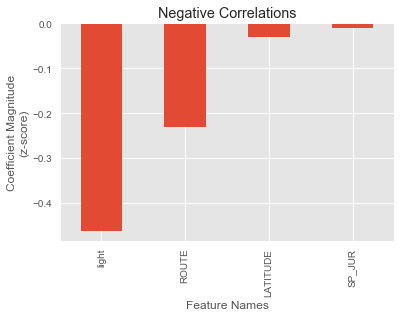

In [82]:
#
bnb = LogisticRegression()
bnb.fit(x_collision_train_scl,y_collision_train)
y_hat = bnb.predict(x_collision_test_scl)

#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = bnb.coef_.T.flatten()
#print(weights)
feature_names = x_collision_df.columns
#print(feature_names)
bnb_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
bnb_ft_imp_df.sort_values(by='weights', inplace=True)

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = bnb_ft_imp_df.head(4)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar')

ax.set_title("Negative Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

# sort these attributes and spit them out
# zip_vars = zip(lr.coef_.T,x_fatals_df.columns) # combine attributes
# for coef, name in sorted(zip_vars):
#     print(name, 'has weight of', coef[0]) # now print them out

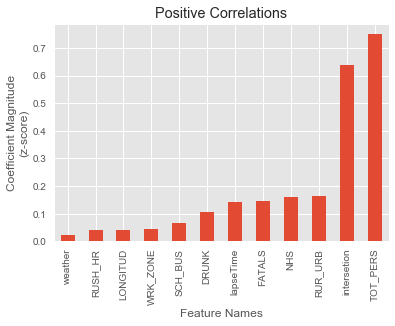

In [78]:
#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = bnb_ft_imp_df.tail(12)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar')

ax.set_title("Positive Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()


The plots above show both the negative and positive coorelations of key features.  Total persons (TOT_PERS) and intersection are strong positive correlations to collisions.  Poor lighting (lighting) and smaller routes (ROUTE) are the two most negatively coorelated features to collisions.

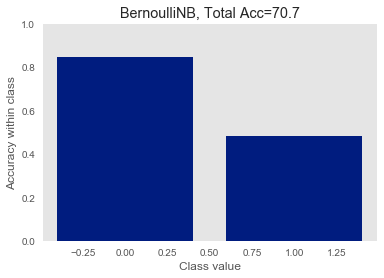

In [125]:
# Visualize the Accuracy of the GaussianNB 

def per_class_accuracy(ytrue,y_hat):
    conf = mt.confusion_matrix(ytrue,y_hat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,y_hat, title=''):
    acc_list = per_class_accuracy(ytrue,y_hat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,y_hat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()


plot_class_acc(y_collision_test,y_hat,title="BernoulliNB")

With the nature of our classifications, the bar chart above looks better due to the fact that collision is a better representation of a binary variable than the number of fatalities. Collision was not perfectly split but it was approximately 60/40 as opposed to the 90/10 of our fatalities variable.

In [126]:
from sklearn import metrics as mt

# get various measures of performance
total_accuracy = mt.accuracy_score(y_collision_test,y_hat)
per_class_acc_list = per_class_accuracy(y_collision_test,y_hat)

rec_tot = []
prec_tot = []

for cls in np.unique(y_collision_test):
    idx = (y_collision_test==cls) # get classes
    ytmp_actual = np.zeros(y_collision_test.shape) # make binary class problem
    ytmp_actual[idx] = 1          # set the instances for this specific class
    
    ytmp_predicted = np.zeros(y_collision_test.shape) # binary prediction array
    ytmp_predicted[y_hat==cls] = 1 
    
    num_in_class = sum(idx)
    
    rec = mt.recall_score(ytmp_actual, ytmp_predicted)
    prec = mt.precision_score(ytmp_actual, ytmp_predicted)
    rec_tot.append(rec)
    prec_tot.append(prec)
        
print ('Total Accuracy:',total_accuracy)

Total Accuracy: 0.707025178738


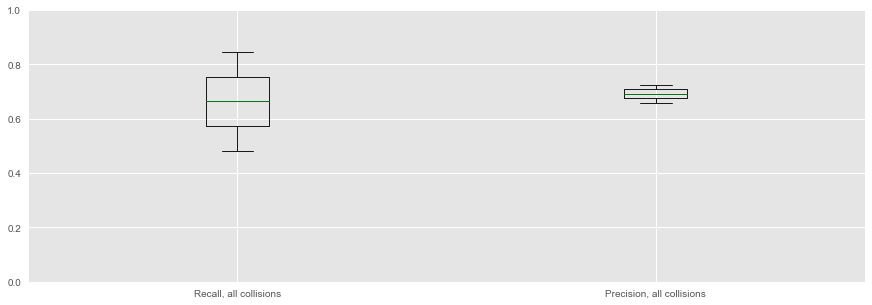

In [127]:
# But we can really summarize this data much better than this. 
# How about looking at more statistics of the precision and recall for each class?

import seaborn as sns
sns.set_palette("dark")
plt.figure(figsize=(15,5))
plt.boxplot([ rec_tot, prec_tot],
            labels=['Recall, all collisions','Precision, all collisions'])
plt.ylim([0,1])
plt.show()

The box and whisker plots shown here provide a quick view of the statistical composition of the precision and recall of our chosen model. The ends represent the floor (lowest) and ceiling (highest) values. The top and bottom of the boxes represent the values at 25% and 75% of our plotted data, while the median value is shown by the center line.

# Deployment

The prediction of multi-fatality accidents could be valuable to many government agencies when determining the variables that lead to this catastrophic outcome. Understanding the primary factors that contribute the most to loss of life in motor vehicle accidents, prevention programs can be established to educate and address these causes. Most people would speculate that drunk driving leads to more fatalities, and the model confirms that multiple fatalities are strongly correlated to drunk driving. Vehicle collisions are the second greatest factor in multiple fatality accidents. This information can be used in defensive driving training to stress collision avoidance as a means of staying alive.

Following that, the identification of factors involved in vehicle collisions can be further utilized in defensive driving and driver's education courses. For exapmle, there is a higher probability that a work zone will be involved when the accident involves a collision of more than one vehicle. One possible application of this information could be to offer more training in driver's education courses surrounding appropriate modification of driving behavior when approaching or driving through a work zone. Further, the allocation of more funds to allow for extra signage in work zones or additional lights identifying work-zone vehicles--which are often slow-moving and can be involved in accidents with other, faster vehicles.

Currently, datasets regarding traffic fatalities are released each year and could be used to update these models accordingly. While it would be helpful to do this more often, it is likely infeasible due to the time-consuming nature and difficulty of collecting all of this information.


# Exceptional Work


For exceptional work, we utilized a **grid search** for each of the models above to determine the best set of parameters for each.  Additionally, a function for classifier estimation was used to compare each model using accuracy, precision, and recall.

Additionally, **new features** were developed from the dataset.  The feature RUSH_HR was created to determine if rush hour traffic was a key factor in fatalities and collisions.  The feature lapseTime represents the time between the crash occuring and when EMS delivers the victim to the hospital, and was also a factor in determining whether a collision occurred.

**New ordinal variables** were also created for lighting condition and weather condition.  The original variables for lighting (LGT_COND) was reordered to represent a new ordinal variable (light) to scale from lightest to darkest conditions.  Similarly, the original variable for weather condition (WEATHER) was reordered to represent a new ordinal variable (weather) to scale from best to worst weather conditions.
